In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from ntpath import splitext

os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
print(os.getenv("TF_GPU_ALLOCATOR"))

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2025-06-08 17:43:49.514976: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749397429.588015    3441 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749397429.606169    3441 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749397429.734782    3441 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749397429.734803    3441 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749397429.734807    3441 computation_placer.cc:177] computation placer alr

cuda_malloc_async
Num GPUs Available:  1


In [2]:
IMG_SIZE = 128
INPUT_CHANNELS = 3
OUTPUT_CHANNELS = 6

In [3]:
def build_tensors(dir_path):
    """
    This function builds a tensor from the images at a given path.
    It concatenates the two single exposed sources of each double exposed image into one and add it to the tensor.
    The function also normalizes them to the range [0, 1].
    
    Args:
        dir_path (str): The path to the directory of the dataset.
        
    Returns:
        tf.Tensor: Tensor of input images.
        tf.Tensor: Tensor of labels, the two sources images.
    """
    # get number of images
    num_images = sum(1 for img in os.listdir(dir_path + "double_exposure/") if img.endswith('.jpg'))

    x = np.zeros((num_images, IMG_SIZE, IMG_SIZE, INPUT_CHANNELS), dtype=np.float32)
    y = np.zeros((num_images, IMG_SIZE, IMG_SIZE, OUTPUT_CHANNELS), dtype=np.float32)

    i = 0
    for img in os.listdir(dir_path + "double_exposure/"):
        if img.endswith('.jpg'):
            img_name = splitext(img)[0]
            img_name = img_name[6:]
            img1 = img_name.split('-')[0] + '.jpg'
            img2 = img_name.split('-')[1] + '.jpg'

            img1_path = os.path.join(dir_path + "single_exposure/", img1)
            img2_path = os.path.join(dir_path + "single_exposure/", img2)
            image1 = tf.io.read_file(img1_path)
            image1 = tf.image.decode_jpeg(image1, channels=3)
            image2 = tf.io.read_file(img2_path)
            image2 = tf.image.decode_jpeg(image2, channels=3)
            image1 = tf.cast(image1, tf.float32) / 255.0
            image2 = tf.cast(image2, tf.float32) / 255.0
            label = tf.concat([image1, image2], axis=2)
            y[i] = label
            image = tf.io.read_file(os.path.join(dir_path + "double_exposure/", img))
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.cast(image, tf.float32) / 255.0
            x[i] = image
        i += 1
    
    return x, y


In [4]:
def create_model(input_shape=(128, 128, 3)):

    # Define the input layer
    input_layer = tf.keras.layers.Input(shape=input_shape)  
    

    # Encoder
    conv1 = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input_layer)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)   

    conv2 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(96, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = tf.keras.layers.Conv2D(160, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    pool5 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv5)

    conv6 = tf.keras.layers.Conv2D(192, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool5)
    pool6 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv6)


    # Decoder
    upconv1 = tf.keras.layers.Conv2DTranspose(96, 3, activation = 'relu', strides=(2, 2), padding='same')(pool6)
    upconv1 = tf.keras.layers.Concatenate()([upconv1, conv6])

    upconv2 = tf.keras.layers.Conv2DTranspose(64, 3, activation = 'relu', strides=(2, 2), padding='same')(upconv1)
    upconv2 = tf.keras.layers.Concatenate()([upconv2, conv5])

    upconv3 = tf.keras.layers.Conv2DTranspose(32, 3, activation = 'relu', strides=(2, 2), padding='same')(upconv2)
    upconv3 = tf.keras.layers.Concatenate()([upconv3, conv4])

    upconv4 = tf.keras.layers.Conv2DTranspose(16, 3, activation = 'relu', strides=(2, 2), padding='same')(upconv3)
    upconv4 = tf.keras.layers.Concatenate()([upconv4, conv3])

    upconv5 = tf.keras.layers.Conv2DTranspose(8, 3, activation = 'relu', strides=(2, 2), padding='same')(upconv4)
    upconv5 = tf.keras.layers.Concatenate()([upconv5, conv2])

    upconv6 = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 3, activation = 'tanh', strides=(2, 2), padding='same')(upconv5)
    

    model = tf.keras.Model(input_layer, upconv6)
    print(model.summary())

    return model

In [5]:
# Load the dataset
dataset_dir = "/home/cycy/Documents/datasets/PISC/img_decomposition_dataset"

x_train, y_train = build_tensors(dataset_dir + "/train/")
x_test, y_test = build_tensors(dataset_dir + "/test/")
x_val, y_val = build_tensors(dataset_dir + "/val/")

print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)



I0000 00:00:1749397446.293265    3441 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1749397446.295045    3441 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3620 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


x_train shape:  (3500, 128, 128, 3)
y_train shape:  (3500, 128, 128, 6)


In [6]:
# Crossroad l1 Loss function

def crossroad_l1_loss(y_true, y_pred):
    y_true1 = y_true[:, :, :, :3]
    y_true2 = y_true[:, :, :, 3:]
    y_pred1 = y_pred[:, :, :, :3]
    y_pred2 = y_pred[:, :, :, 3:]
    d11 = tf.reduce_mean(tf.abs(y_pred1 - y_true1))
    d12 = tf.reduce_mean(tf.abs(y_pred1 - y_true2))
    d21 = tf.reduce_mean(tf.abs(y_pred2 - y_true1))
    d22 = tf.reduce_mean(tf.abs(y_pred2 - y_true2))
    return tf.minimum(d11 + d22, d12 + d21)



In [7]:
# Create model

batch_size = 8
epochs = 50
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = tf.keras.losses.BinaryCrossentropy()

model = create_model(input_shape=(IMG_SIZE, IMG_SIZE, INPUT_CHANNELS))

model.compile(loss=loss,
              optimizer=opt,
              )

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     55,392 │ max_pooling2d_1[… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │    110,720 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 128) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 160) │    184,480 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 4, 4, 160) │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 192) │    276,672 │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 2, 2, 192) │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 4, 4, 96)  │    165,984 │ max_pooling2d_5[… │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4, 4, 288) │          0 │ conv2d_transpose… │
│ (Concatenate)       │                   │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 8, 8, 64)  │    165,952 │ concatenate[0][0] │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 8, 8, 224) │          0 │ conv2d_transpose… │
│ (Concatenate)       │                   │            │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,078,158 (4.11 MB)

 Trainable params: 1,078,158 (4.11 MB)

 Non-trainable params: 0 (0.00 B)

None


In [8]:
# Training the model

with tf.device('/GPU:0'):
    history = model.fit(
        x_train, 
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_val, y_val))

# Save the model
model.save_weights('./result_weights/model_v1.weights.h5')

2025-06-08 17:44:49.065081: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1376256000 exceeds 10% of free system memory.
2025-06-08 17:44:49.786524: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1376256000 exceeds 10% of free system memory.


Epoch 1/50


I0000 00:00:1749397492.295664    3599 service.cc:152] XLA service 0x7a012000be10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749397492.295682    3599 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-06-08 17:44:52.357681: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749397492.766428    3599 cuda_dnn.cc:529] Loaded cuDNN version 90300


 19/438 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 4.1350

I0000 00:00:1749397497.472571    3599 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


438/438 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 1.9294 - val_loss: 0.6228
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.6138 - val_loss: 0.6115
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.6046 - val_loss: 0.6061
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.6004 - val_loss: 0.6034
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.5975 - val_loss: 0.6021
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.5973 - val_loss: 0.6011
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.5963 - val_loss: 0.6003
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.5951 - val_loss: 0.5998
Epoch 9/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.5937 - val_loss: 0.5992
Epoch 10/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.5959 - val_loss: 0.5986
Epoch 11/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.5937 - val_loss: 0.5985
Epoch 12/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 

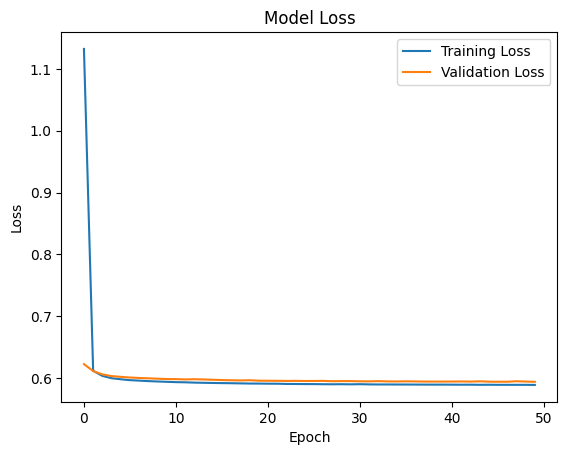

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
y_pred shape:  (30, 128, 128, 6)


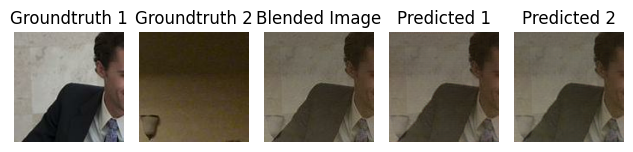

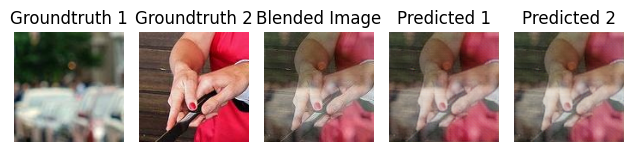

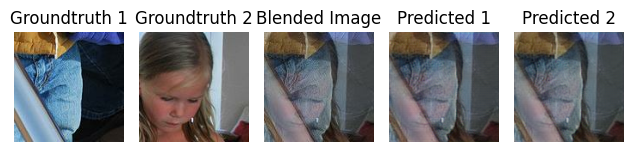

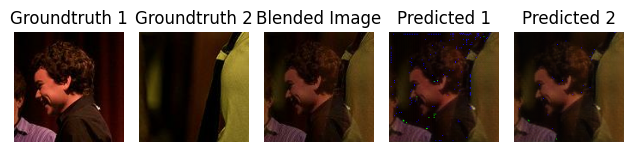

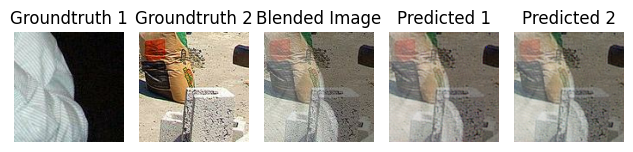

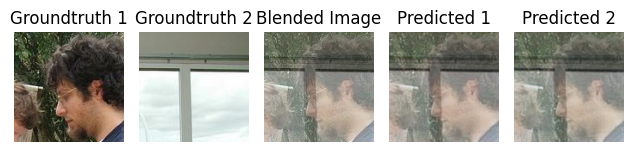

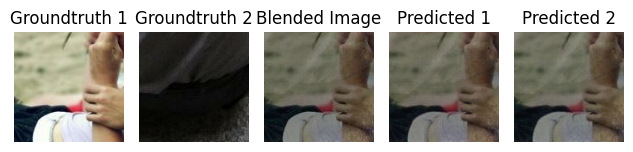

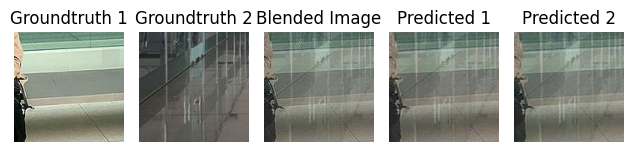

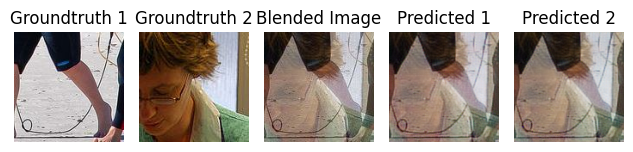

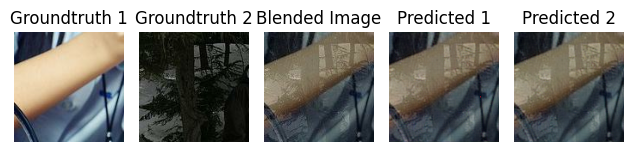

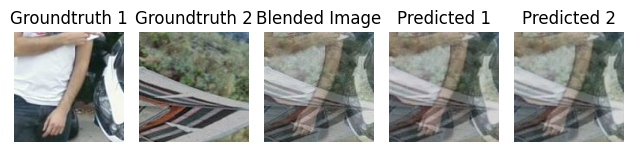

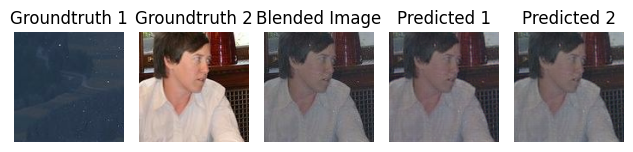

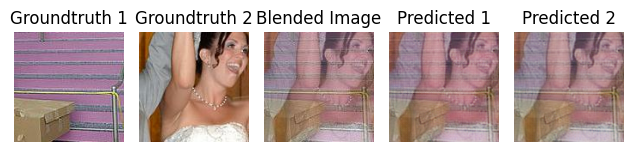

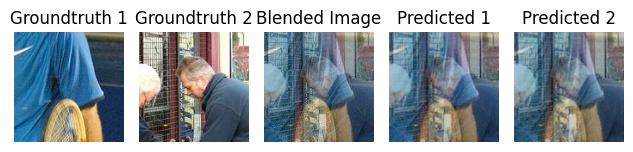

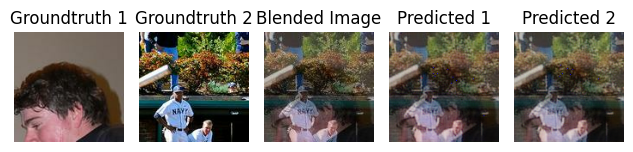

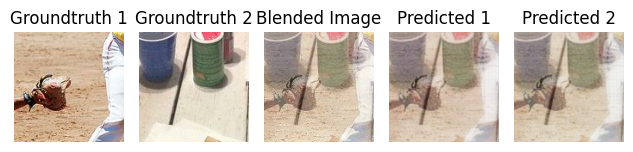

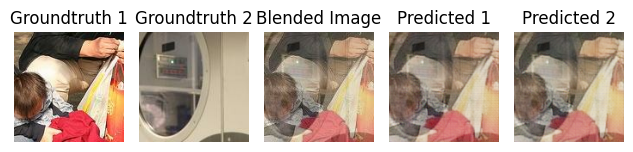

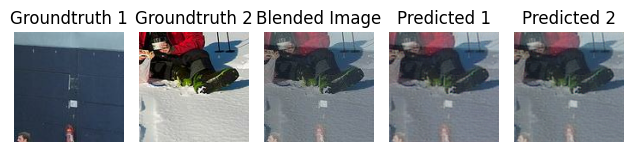

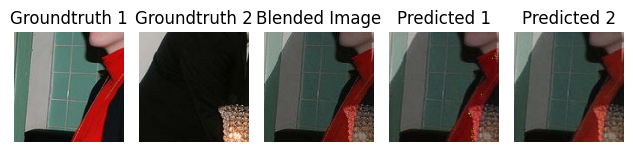

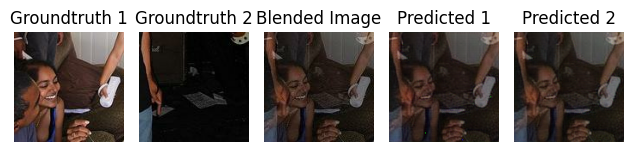

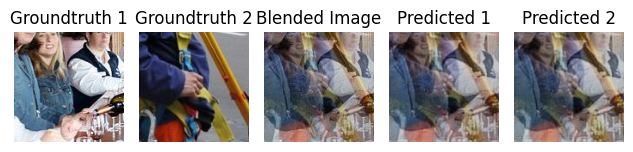

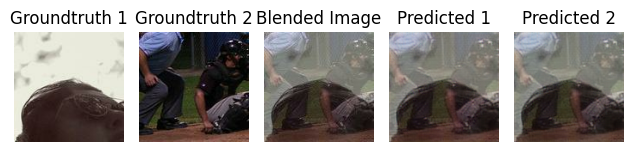

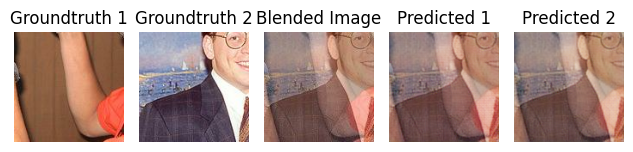

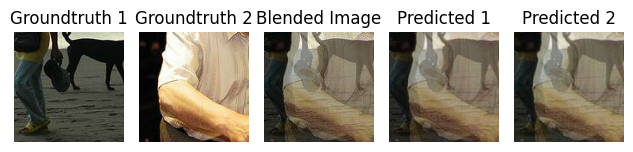

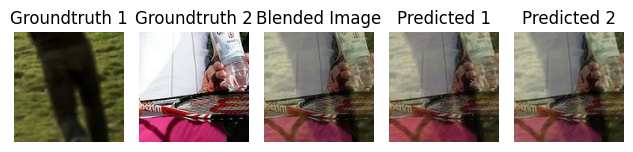

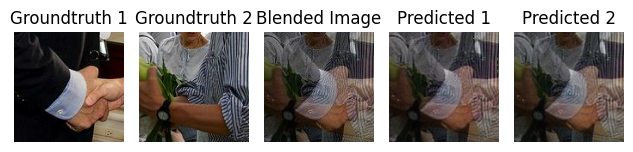

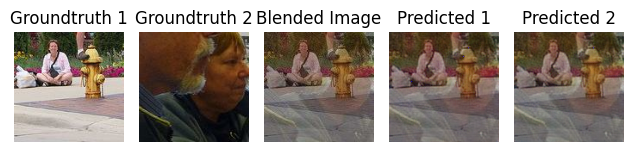

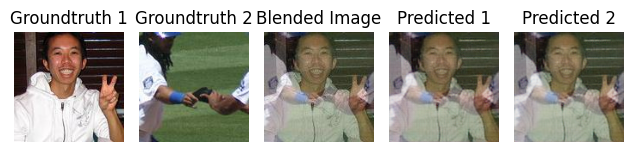

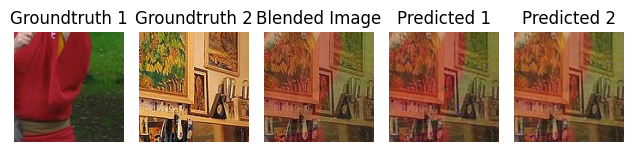

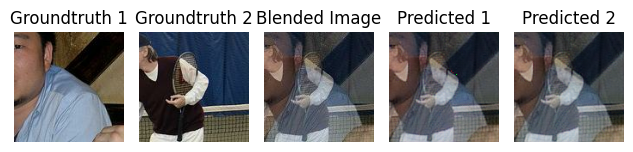

In [10]:
# Results

# model.load_weights("./result_weights/model_v1.weights.h5")

# Loss graph
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


# Qualitative results
n_images_show = 30

y_pred = model.predict(x_test[0:n_images_show])
print("y_pred shape: ", y_pred.shape)

y_pred_1, y_pred_2 = tf.split(y_pred, num_or_size_splits=2, axis=-1)
y_pred_1 = y_pred_1 * 255.0
y_pred_1 = tf.cast(y_pred_1, tf.uint8)
y_pred_2 = y_pred_2 * 255.0
y_pred_2 = tf.cast(y_pred_2, tf.uint8)

y_truth_1, y_truth_2 = tf.split(y_test[0:n_images_show], num_or_size_splits=2, axis=-1)
y_truth_1 = y_truth_1 * 255.0
y_truth_1 = tf.cast(y_truth_1, tf.uint8)
y_truth_2 = y_truth_2 * 255.0
y_truth_2 = tf.cast(y_truth_2, tf.uint8)

x_test_denormalized = x_test[0:n_images_show] * 255.0
x_test_denormalized = tf.cast(x_test_denormalized, tf.uint8)

i = 0
for i in range(n_images_show):
    y_pred_img1 = y_pred_1[i]
    y_pred_img2 = y_pred_2[i]
    x_test_img = x_test_denormalized[i]
    y_truth_img1 = y_truth_1[i]
    y_truth_img2 = y_truth_2[i]

    # show the images near each other
    plt.subplot(1, 5, 1)
    plt.title("Groundtruth 1")
    plt.imshow(y_truth_img1)
    plt.axis('off')
    plt.subplot(1, 5, 2)
    plt.title("Groundtruth 2")
    plt.imshow(y_truth_img2)
    plt.axis('off')
    plt.subplot(1, 5, 3)
    plt.title("Blended Image")
    plt.imshow(x_test_img)
    plt.axis('off')
    plt.subplot(1, 5, 4)
    plt.title("Predicted 1")
    plt.imshow(y_pred_img1)
    plt.axis('off')
    plt.subplot(1, 5, 5)
    plt.title("Predicted 2")
    plt.imshow(y_pred_img2)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    i += 1
    if i > n_images_show:
        break


